In [3]:
import matplotlib.pyplot as plt
from stompy import utils
import stompy.model.schism.schism_model as sch
import numpy as np
import os
%matplotlib notebook

In [4]:
# 
run_dirs=['../data_schmouth_v020']

In [5]:
run_dir=run_dirs[0]
ms=sch.MultiSchism(os.path.join( run_dir, 'hgrid.gr3'),
                   os.path.join(run_dir,'outputs','schout_*_2.nc'))

<IPython.core.display.Javascript object>


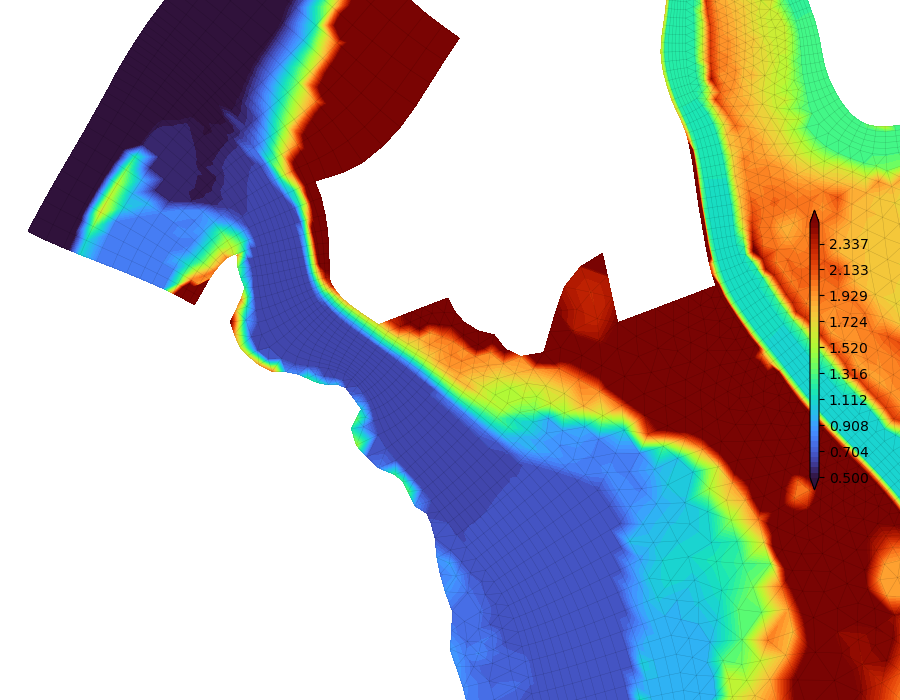

(551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551)

In [58]:
fig,ax=plt.subplots(figsize=(9,7))

ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
cset=ms.grid.contourf_node_values(ms.elev.isel(time=6).values,
                                  np.linspace(0.5,2.5,50),extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)
ax.axis((551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551))

In [53]:
ax.axis()

(551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551)

<IPython.core.display.Javascript object>


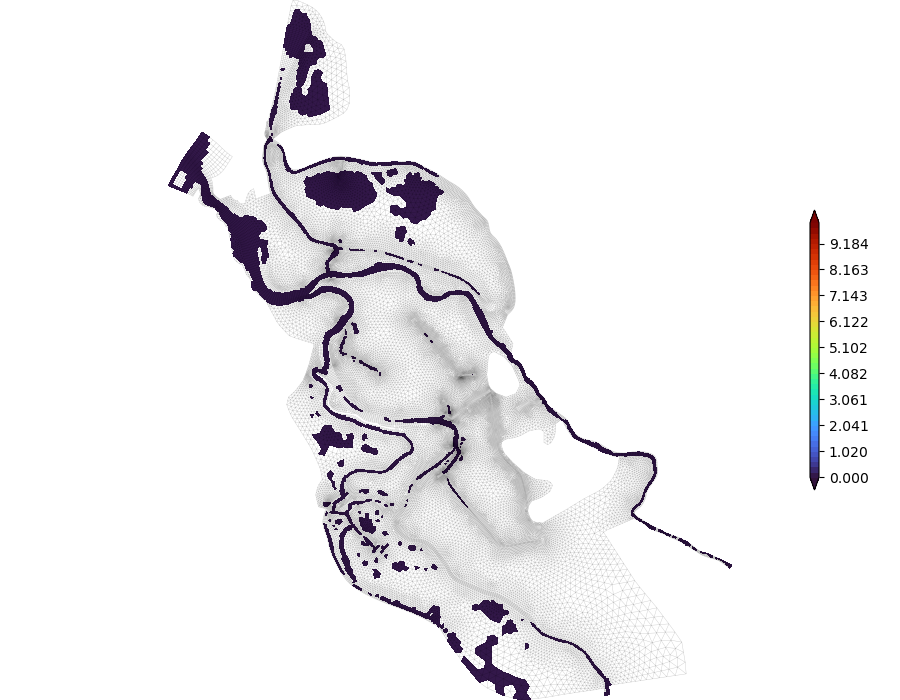

In [10]:
# Surface salinity:
fig,ax=plt.subplots(figsize=(9,7))

ti=-1
ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
wet_cell=ms.wetdry_elem.isel(time=ti).values<0.5

#data=ms.salt.isel(time=ti,nSCHISM_vgrid_layers=-1).values

s_top=ms.salt.isel(time=ti,nSCHISM_vgrid_layers=-1).values
s_bed=ms.salt.isel(time=ti,nSCHISM_vgrid_layers=0).values
data=s_bed-s_top

cset=ms.grid.contourf_node_values(data,
                                  np.linspace(0,10,50),
                                  tri_kwargs=dict(cell_mask=wet_cell),
                                  extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)

<IPython.core.display.Javascript object>


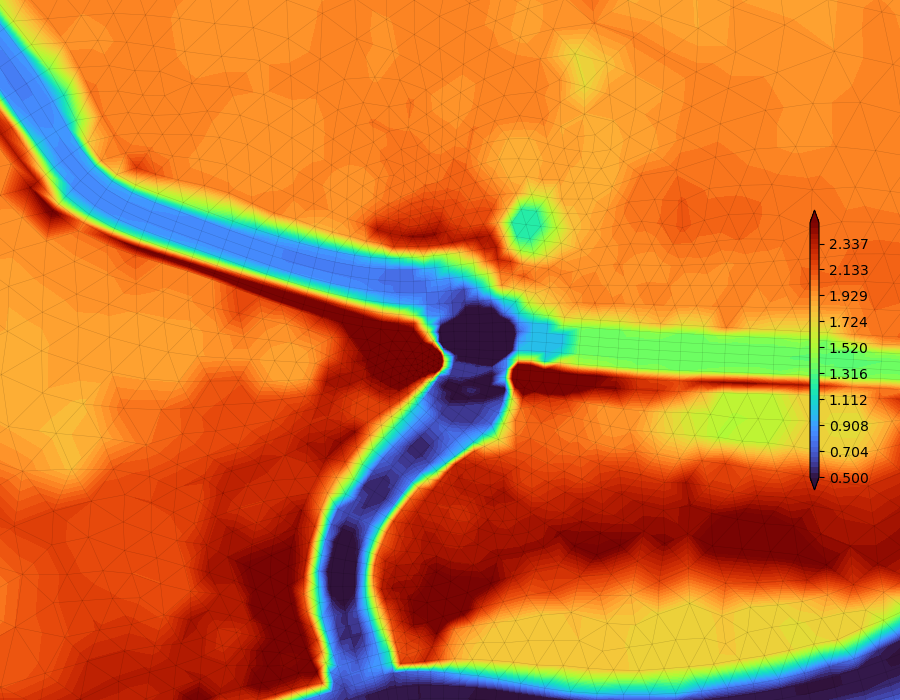

In [15]:
fig,ax=plt.subplots(figsize=(9,7))

ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
cset=ms.grid.contourf_node_values(-ms.grid.nodes['depth'],
                                  np.linspace(0.5,2.5,50),extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)

In [13]:
# Read in stations

# model.run_dir



# These outputs are invoked with iout_sta=1, and are found in outputs/staout_[1..,9], corresponding
# respectively to elev, air pressure, wind u, wind v, T, S, u, v, w. Each output has a simple ASCII
# format:
# Time(sec), variable @ station 1,2,…. (specified in station.in)




(316, 1031)

In [16]:
import xarray as xr


In [30]:
def read_stations(run_dir):
    fp=open(os.path.join(run_dir,'station.in'))
    flags=fp.readline().split('!')[0].split()[:9] # longer for more tracers?
    flags=[int(f) for f in flags]
    n_stations=int(fp.readline().split('!')[0].split()[0])
    stations=np.loadtxt(fp)
    return flags, stations


In [32]:
import stompy.model.schism.schism_model as sch
import datetime
def station_output(run_dir):
    param=sch.Namelist(os.path.join(run_dir,'param.nml'))
    start_dt=datetime.datetime(year=int(param['OPT','start_year']),
                               month=int(param['OPT','start_month']),
                               day=int(param['OPT','start_day']))

    t_start=np.datetime64(start_dt) + float(param['OPT','start_hour'])*3600*np.timedelta64(1,'s')
    flags,stations=read_stations(run_dir)

    ds=xr.Dataset()
    # Would be nice present the data both as points and as profiles.
    ds['x']=('station',), stations[:,1]
    ds['y']=('station',), stations[:,2]
    ds['z']=('station',), stations[:,3]

    names=['elev','airpressure','wind_u','wind_v','temp','salt','u','v','w']
    
    for i,flag in enumerate(flags):
        if flag==0: continue
        sta_fn=os.path.join(run_dir,'outputs','staout_%d'%(i+1))
        sta_raw=np.loadtxt(sta_fn)
    
        if 'time' not in ds.dims:
            ds['time_s']=('time',),sta_raw[:,0]
            ds['time']=('time',),t_start+ds['time_s']*np.timedelta64(1,'s')
        
        ds[names[i]]=('time','station'),sta_raw[:,1:]

    return ds

In [33]:
ds=station_output(run_dir)

<IPython.core.display.Javascript object>


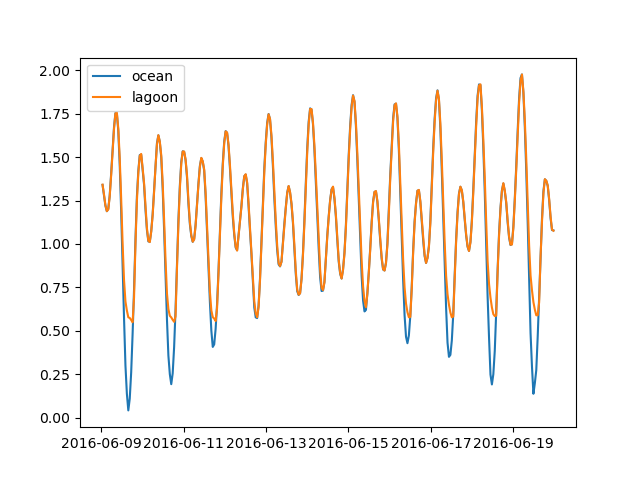

In [50]:
# Find a spot in the lagoon, and a spot near the ocean
xy_ocean=[552041.12, 4124763.48]
xy_lagoon=[552277.89, 4124400.70]

sta_ocean=np.argmin( utils.dist(np.c_[ds.x, ds.y], xy_ocean))
sta_lagoon=np.argmin( utils.dist(np.c_[ds.x, ds.y], xy_lagoon))

plt.figure()
plt.plot(ds.time,ds['elev'].isel(station=sta_ocean),label='ocean')
plt.plot(ds.time,ds['elev'].isel(station=sta_lagoon),label='lagoon')
plt.legend()

<IPython.core.display.Javascript object>


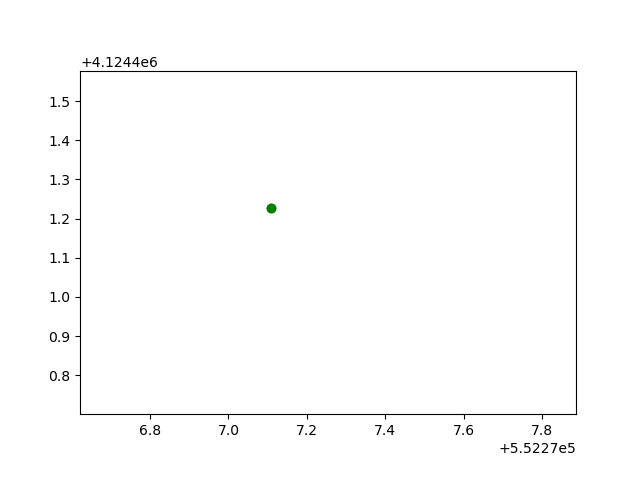

In [36]:
#plt.figure()
#ms.grid.plot_edges(color='k',lw=0.3)
#plt.plot(ds.x,ds.y,'go')